## DeepWalk详解

[Paper:Tang J, Qu M, Wang M, et al. Line: Large-scale information network embedding](https://arxiv.org/pdf/1503.03578.pdf)

In [1]:
from gensim.models import Word2Vec
import pandas as pd
import networkx as nx
import random

### 读取数据

In [2]:
# 读取节点之间的边
G = nx.read_edgelist('../../data/wiki/Wiki_edgelist.txt',
                         create_using=nx.DiGraph(), nodetype=None,
                         data=[('weight', int)])

## 随机游走

In [5]:
walker = RandomWalker(G, p=1, q=1, )

#### 获取节点访问序列

In [6]:
num_walks = 1
walk_length = 3
workers = 1
sentences = walker.simulate_walks(
            num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=0)

### 训练模型

In [9]:
embed_size=128
window_size=5
workers=3
iter=5
kwargs = {}
kwargs["sentences"] = sentences
kwargs["min_count"] = 0
kwargs["size"] = embed_size
kwargs["sg"] = 1  # skip gram
kwargs["hs"] = 1  # deepwalk use Hierarchical Softmax
kwargs["workers"] = workers
kwargs["window"] = window_size
kwargs["iter"] = iter

In [11]:
print("Learning embedding vectors...")
model = Word2Vec(**kwargs)
print("Learning embedding vectors done!")

Learning embedding vectors...
Learning embedding vectors done!


### 生成嵌入向量

In [12]:
embeddings = {}
for word in G.nodes():
    embeddings[word] = model.wv[word]

In [14]:
embeddings['362']

array([-8.3426051e-03, -9.7931328e-04, -1.6034893e-03, -3.1504526e-03,
       -7.4993455e-05,  1.1755643e-02, -2.0438435e-03, -1.0911431e-03,
        6.9341655e-03,  2.0922110e-03, -7.6386416e-03, -1.0063763e-03,
       -9.0222526e-03,  1.1107128e-03, -3.7842307e-03,  8.1276027e-03,
        6.4620501e-03, -2.4647908e-03,  3.2307431e-03, -3.4814484e-03,
        1.4803627e-03, -1.1866836e-02,  6.8992763e-03,  3.6213682e-03,
        3.0801570e-04, -1.8231458e-03,  8.2952548e-03, -2.9112529e-03,
        1.0556733e-03, -5.8907145e-03, -2.5527414e-03,  6.8176407e-03,
       -1.4277349e-03, -8.1478739e-03,  3.6709043e-03,  1.6700079e-03,
       -3.1968040e-04,  1.1473600e-03, -7.1786800e-03,  8.3548659e-03,
        1.3978640e-04,  6.2810071e-04,  9.2273224e-03, -2.7269756e-03,
        6.7464524e-04, -1.1362178e-02,  4.5905900e-03, -1.2667043e-02,
        6.2176520e-03,  8.9974841e-03, -4.7857473e-03, -4.9619651e-03,
        3.6171759e-03, -6.6841603e-03, -6.4186808e-03,  9.8616490e-04,
      

### 评估

In [26]:
from sklearn.manifold import TSNE
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [27]:
def evaluate_embeddings(embeddings):
    X, Y = read_node_label('../../data/wiki/wiki_labels.txt')
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)


def plot_embeddings(embeddings,):
    X, Y = read_node_label('../../data/wiki/wiki_labels.txt')

    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()


Training classifier using 80.00% nodes...


G:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


-------------------
{'micro': 0.16424116424116425, 'macro': 0.0258907401732286, 'samples': 0.16424116424116425, 'weighted': 0.06644278582858239, 'acc': 0.16424116424116425}


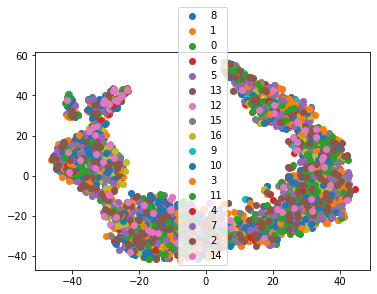

In [29]:
evaluate_embeddings(embeddings)
plot_embeddings(embeddings)

## 定义随机游走

In [4]:
class RandomWalker:
    def __init__(self, G, p=1, q=1):
        """
        :param G:
        param p: 返回参数，控制立即重新遍历节点的可能性。.

        param q: In-out参数，允许搜索区分“向内”和“向外”节点
        """
        self.G = G
        self.p = p
        self.q = q
    
    # 选取节点的方式采用的是又放回的随机选取
    # RandomWalk是一种可重复访问已访问节点的深度优先遍历
    def deepwalk_walk(self, walk_length, start_node):
#         开始节点
        walk = [start_node]
#         到达长度停止
        while len(walk) < walk_length:
            cur = walk[-1]
#             获取当前节点中的邻居节点
            cur_nbrs = list(self.G.neighbors(cur))
            if len(cur_nbrs) > 0:
#                 从邻居节点中随机获取一个节点
                walk.append(random.choice(cur_nbrs))
            else:
                break
        return walk

    def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):
#         :num_walks  将所有节点随机游走的次数
#         :walk_length 每次游走的长度

        G = self.G

        nodes = list(G.nodes())
        walks = self._simulate_walks(nodes,num_walks,walk_length)
        
#         多线程同时处理
#         results = Parallel(n_jobs=workers, verbose=verbose, )(
#         delayed(self._simulate_walks)(nodes, num, walk_length) for num in
#         partition_num(num_walks, workers))

#         walks = list(itertools.chain(*results))

        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length,):
#         :num_walks  将所有节点随机游走的次数
#         :walk_length 每次游走的长度
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                if self.p == 1 and self.q == 1:
                    walks.append(self.deepwalk_walk(
                        walk_length=walk_length, start_node=v))
                else:
                    walks.append(self.node2vec_walk(
                        walk_length=walk_length, start_node=v))
        return walks

    def get_alias_edge(self, t, v):
        """
        compute unnormalized transition probability between nodes v and its neighbors give the previous visited node t.
        :param t:
        :param v:
        :return:
        """
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for x in G.neighbors(v):
            weight = G[v][x].get('weight', 1.0)  # w_vx
            if x == t:  # d_tx == 0
                unnormalized_probs.append(weight/p)
            elif G.has_edge(x, t):  # d_tx == 1
                unnormalized_probs.append(weight)
            else:  # d_tx > 1
                unnormalized_probs.append(weight/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [
            float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return create_alias_table(normalized_probs)

    def preprocess_transition_probs(self):
        """
        Preprocessing of transition probabilities for guiding the random walks.
        """
        G = self.G

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr].get('weight', 1.0)
                                  for nbr in G.neighbors(node)]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [
                float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = create_alias_table(normalized_probs)

        alias_edges = {}

        for edge in G.edges():
            alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return


### Classifier 

In [16]:
from __future__ import print_function


import numpy
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer


class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = numpy.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return numpy.asarray(all_labels)


class Classifier(object):

    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = TopKRanker(clf)
        self.binarizer = MultiLabelBinarizer(sparse_output=True)

    def train(self, X, Y, Y_all):
        self.binarizer.fit(Y_all)
        X_train = [self.embeddings[x] for x in X]
        Y = self.binarizer.transform(Y)
        self.clf.fit(X_train, Y)

    def evaluate(self, X, Y):
        top_k_list = [len(l) for l in Y]
        Y_ = self.predict(X, top_k_list)
        Y = self.binarizer.transform(Y)
        averages = ["micro", "macro", "samples", "weighted"]
        results = {}
        for average in averages:
            results[average] = f1_score(Y, Y_, average=average)
        results['acc'] = accuracy_score(Y,Y_)
        print('-------------------')
        print(results)
        return results
        print('-------------------')

    def predict(self, X, top_k_list):
        X_ = numpy.asarray([self.embeddings[x] for x in X])
        Y = self.clf.predict(X_, top_k_list=top_k_list)
        return Y

    def split_train_evaluate(self, X, Y, train_precent, seed=0):
        state = numpy.random.get_state()

        training_size = int(train_precent * len(X))
        numpy.random.seed(seed)
        shuffle_indices = numpy.random.permutation(numpy.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(training_size)]
        Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
        X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
        Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]

        self.train(X_train, Y_train, Y)
        numpy.random.set_state(state)
        return self.evaluate(X_test, Y_test)


def read_node_label(filename, skip_head=False):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        if skip_head:
            fin.readline()
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        Y.append(vec[1:])
    fin.close()
    return X, Y